# Кейс 3. Команда 6

### Задание 1
Подготовка и очистка текстов:

a.	Удалить пунктуацию, спецсимволы, лишние пробелы

b.	Привести текст к нижнему регистру

c.	Провести токенизацию, лемматизацию (с помощью nltk, spacy)

d.	Удалить стоп-слова


In [42]:
import pandas as pd
import re #регулярные выражения для удаления спецсимволов
import string #для удаления пунктуации
import nltk #одна из библиотек на выбор для работы с естественным языком
from nltk.corpus import stopwords #стоп-слова
from nltk.stem import WordNetLemmatizer #лемматизация
from typing import List

In [43]:
# Загрузка необходимых ресурсов NLTK
nltk.download('stopwords') #загрузка стоп-слов
nltk.download('wordnet') #загрузка лемматизации

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\narra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\narra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

При выполнении 2го задания было обнаружено, что некоторые из часто повторяющиеся в текстах отзвов слова не находятся в библиотеке стоп-слов nltk, поэтому они были добавлены вручную.

In [44]:
# Расширяем список стоп-слов
additional_stop_words = {'though', 'although'}
stop_words = set(stopwords.words('english')).union(additional_stop_words)
lemmatizer = WordNetLemmatizer()

Также в текстах отзывов часто попадалась html разметка, чтобы избавиться от нее были использованы регулярные выражения.

Также была выбрана простейшая токенизация простым разделением на слова. Английский язык на котором написаны все отзывы не имеет сложной морфологии, также сохраняется высокая скорость обработки. Выбор не окончательный, скорее всего в дальнейшем понадобится токенизация по предложениям, но для 2 задания с подсчетом и анализом слов достаточно .split()

In [45]:
def preprocess_text(text: str) -> List[str]:
    #Приведение к нижнему регистру
    text = text.lower()
    
    # Удаление HTML тегов, сущностей и ссылок
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'&[a-z]+;', ' ', text)
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)
    
    # Удаление пунктуации и спецсимволов
    text = re.sub(f'[{string.punctuation}]', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
   
    # Удаление лишних пробелов
    text = ' '.join(text.split())
    
    # Токенизация по словам
    tokens = text.split()
        
    # Удаление стоп-слов, лемматизация и фильтрация коротких слов
    tokens = [lemmatizer.lemmatize(token) for token in tokens 
                 if token not in stop_words and len(token) > 2]
        
    return tokens

In [68]:
df = pd.read_csv('Reviews.csv')

print("\n10 Оригинальных отзывов:")
print("=" * 80)
for i, review in enumerate(df['Text'].head(10)):
    print(f"\nОригинальный отзыв {i+1}:")
    print(review[:200] + "..." if len(review) > 200 else review)
    
df['Tokens'] = df['Text'].apply(preprocess_text)
df['Processed_Text'] = df['Tokens'].apply(lambda x: ' '.join(x))
    
print("\n10 Обработанных отзывов:")
print("=" * 80)
for i, tokens in enumerate(df['Tokens'].head(10)):
    print(f"\nОбработанный отзыв {i+1}:")
    print(' '.join(tokens[:20]) + "..." if len(tokens) > 20 else ' '.join(tokens))


10 Оригинальных отзывов:

Оригинальный отзыв 1:
I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador...

Оригинальный отзыв 2:
Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".

Оригинальный отзыв 3:
This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powd...

Оригинальный отзыв 4:
If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The flavor...

Оригинальный отзыв 5:
Great taffy at a great price.  There was a wide assortme

KeyboardInterrupt: 

### Задание 2

Разведочный анализ текстов (EDA):

a.	Вычислить длину отзывов (в словах/символах), построить распределения

b.	Построить облака слов (wordcloud) и графики частотности

c.	Исследовать взаимосвязь между оценкой (Rating) и длиной


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

В количествах слов в отзывах есть разброс, большинство отзывов составляют 20-30 слов, но есть определенные выбросы до 2000 слов, с их учетом добавляем фильтрацию для удобства анализа количества слов в отзывах. Используем более строгие квантили 0.15 и 0.85 по сравнению со стандартными чтобы не терять типичные отзывы (при станадартных отсекалось около 10% значений).

In [50]:
def analyze_text_lengths(df):
    # Вычисляем длину в словах и символах
    df['word_count'] = df['Tokens'].str.len()
    df['char_count'] = df['Tokens'].apply(lambda x: sum(len(token) for token in x))
    
    # Вычисляем квантили для фильтрации выбросов
    word_q1, word_q3 = df['word_count'].quantile([0.15, 0.85])
    char_q1, char_q3 = df['char_count'].quantile([0.15, 0.85])
    
    # Вычисляем межквартильный размах
    word_iqr = word_q3 - word_q1
    char_iqr = char_q3 - char_q1
    
    # Определяем границы для фильтрации выбросов
    word_lower = max(0, word_q1 - 1.5 * word_iqr)
    word_upper = word_q3 + 1.5 * word_iqr
    char_lower = max(0, char_q1 - 1.5 * char_iqr)
    char_upper = char_q3 + 1.5 * char_iqr
    
    # Фильтруем данные для визуализации
    df_filtered = df[
        (df['word_count'] >= word_lower) & 
        (df['word_count'] <= word_upper) &
        (df['char_count'] >= char_lower) & 
        (df['char_count'] <= char_upper)
    ]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Распределение длины в словах
    sns.histplot(data=df_filtered, x='word_count', bins=30, ax=ax1, 
                color='skyblue', edgecolor='black')
    ax1.set_title('Распределение длины отзывов (в словах)\nбез выбросов')
    ax1.set_xlabel('Количество слов')
    ax1.set_ylabel('Частота')
    
    # Добавляем вертикальные линии для среднего и медианы
    mean_words = df_filtered['word_count'].mean()
    median_words = df_filtered['word_count'].median()
    ax1.axvline(mean_words, color='red', linestyle='--', alpha=0.5, 
                label=f'Среднее: {mean_words:.1f}')
    ax1.axvline(median_words, color='green', linestyle='--', alpha=0.5, 
                label=f'Медиана: {median_words:.1f}')
    ax1.legend()
    
    # Распределение длины в символах
    sns.histplot(data=df_filtered, x='char_count', bins=30, ax=ax2,
                color='lightgreen', edgecolor='black')
    ax2.set_title('Распределение длины отзывов (в символах)\nбез выбросов')
    ax2.set_xlabel('Количество символов')
    ax2.set_ylabel('Частота')
    
    # Добавляем вертикальные линии для среднего и медианы
    mean_chars = df_filtered['char_count'].mean()
    median_chars = df_filtered['char_count'].median()
    ax2.axvline(mean_chars, color='red', linestyle='--', alpha=0.5,
                label=f'Среднее: {mean_chars:.1f}')
    ax2.axvline(median_chars, color='green', linestyle='--', alpha=0.5,
                label=f'Медиана: {median_chars:.1f}')
    ax2.legend()
    
    # Добавляем информацию о выбросах
    outliers_words = len(df) - len(df_filtered)
    outliers_percent = (outliers_words / len(df)) * 100
    
    fig.suptitle(f'Распределение длины отзывов\n'
                f'Выбросы: {outliers_words} отзывов ({outliers_percent:.1f}% данных)',
                y=1.05)
    
    plt.tight_layout()
    plt.show()
    
    # Анализируем выбросы
    outliers = analyze_outliers(df)
    
    return df_filtered, outliers

Также проведен анализ выбросов

In [51]:
def analyze_outliers(df):
    # Вычисляем квантили и границы для выбросов
    word_q1, word_q3 = df['word_count'].quantile([0.15, 0.85])
    char_q1, char_q3 = df['char_count'].quantile([0.15, 0.85])
    
    word_iqr = word_q3 - word_q1
    char_iqr = char_q3 - char_q1
    
    word_lower = max(0, word_q1 - 1.5 * word_iqr)
    word_upper = word_q3 + 1.5 * word_iqr
    char_lower = max(0, char_q1 - 1.5 * char_iqr)
    char_upper = char_q3 + 1.5 * char_iqr
    
    # Определяем выбросы
    outliers = df[
        (df['word_count'] < word_lower) | (df['word_count'] > word_upper) |
        (df['char_count'] < char_lower) | (df['char_count'] > char_upper)
    ]
    
    # Создаем фигуру с двумя подграфиками
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Распределение выбросов по длине в словах
    sns.histplot(data=outliers, x='word_count', bins=30, ax=ax1,
                color='salmon', edgecolor='black')
    ax1.set_title('Распределение выбросов по длине (в словах)')
    ax1.set_xlabel('Количество слов')
    ax1.set_ylabel('Частота')
    
    # Добавляем вертикальные линии для границ
    ax1.axvline(word_upper, color='red', linestyle='--', alpha=0.5,
                label=f'Верхняя граница: {word_upper:.1f}')
    ax1.legend()
    
    # Распределение выбросов по длине в символах
    sns.histplot(data=outliers, x='char_count', bins=30, ax=ax2,
                color='salmon', edgecolor='black')
    ax2.set_title('Распределение выбросов по длине (в символах)')
    ax2.set_xlabel('Количество символов')
    ax2.set_ylabel('Частота')
    
    # Добавляем вертикальные линии для границ
    ax2.axvline(char_upper, color='red', linestyle='--', alpha=0.5,
                label=f'Верхняя граница: {char_upper:.1f}')
    ax2.legend()
    
    # Добавляем общую информацию
    outliers_count = len(outliers)
    outliers_percent = (outliers_count / len(df)) * 100
    
    fig.suptitle(f'Анализ выбросов в длине отзывов\n'
                f'Всего выбросов: {outliers_count} отзывов ({outliers_percent:.1f}% данных)',
                y=1.05)
    
    plt.tight_layout()
    plt.show()
    
    return outliers

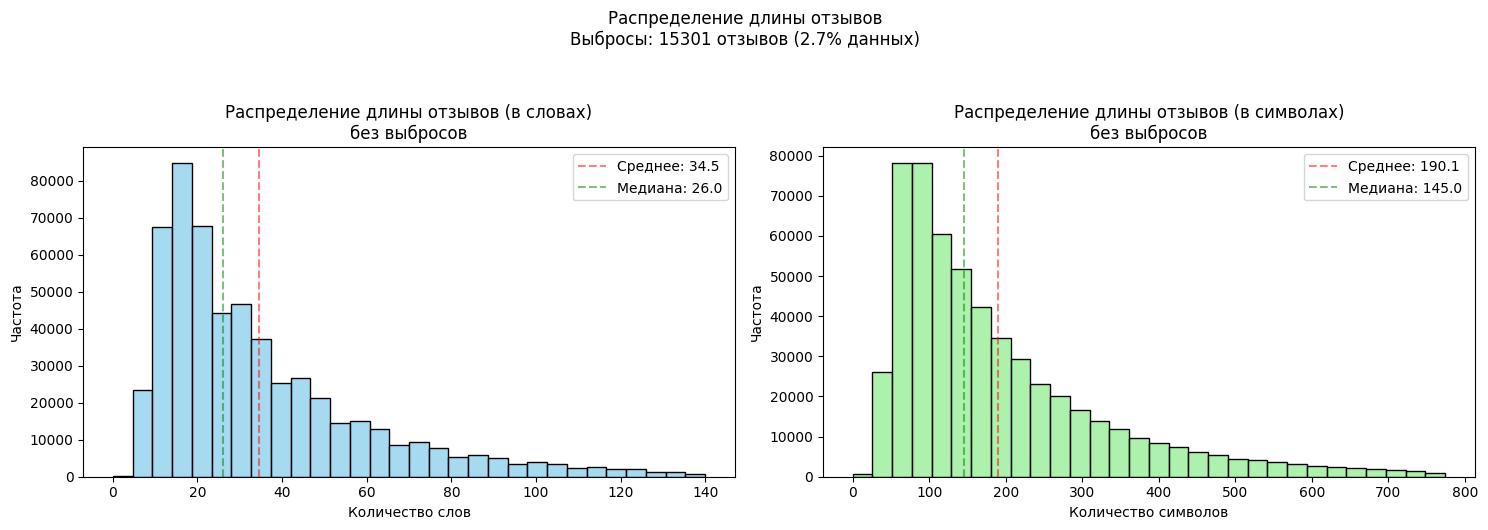

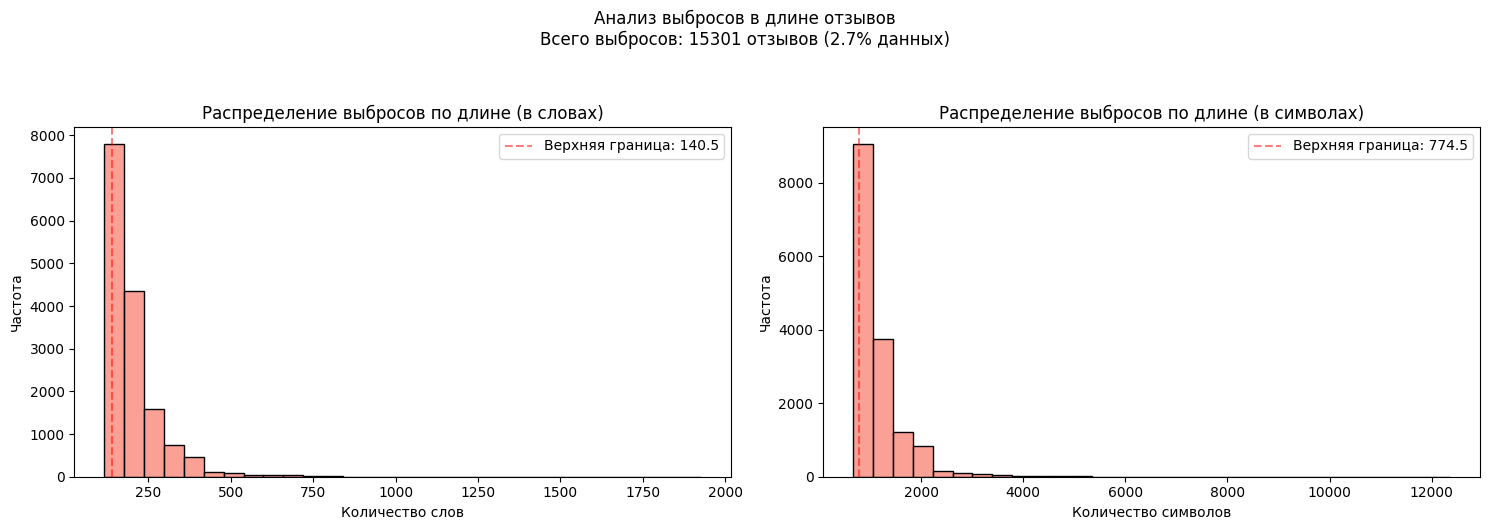

In [52]:
analyze_text_lengths(df);

Для создания облака слов использовали Counter() и подавали данные батчами, чтобы избежать ошибки памяти. 

In [53]:
def create_wordcloud(df, max_words=1000, batch_size=1000):
    # Создание облака слов с обработкой всех текстов порциями для экономии памяти
    
    # Инициализируем счетчик для подсчета частоты слов
    word_freq = Counter()
    
    for i in range(0, len(df), batch_size):
        # Берем текущую порцию данных
        batch = df.iloc[i:i + batch_size]
        # Объединяем токены из текущей порции
        batch_text = ' '.join([' '.join(tokens) for tokens in batch['Tokens'].dropna()])
        # Обновляем счетчик частоты слов
        word_freq.update(batch_text.split())
    
    # Создаем облако слов на основе накопленной частоты слов
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        max_words=max_words,
        contour_width=3,
        contour_color='steelblue',
        collocations=False
    ).generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Облако слов из всех отзывов')
    plt.show()
    
    # Выводим статистику
    total_words = sum(word_freq.values())
    unique_words = len(word_freq)
    print(f"\nСтатистика облака слов:")
    print(f"Всего слов: {total_words:,}")
    print(f"Уникальных слов: {unique_words:,}")
    print(f"Отображено слов в облаке: {max_words:,}")
    
    print("\nТоп-10 самых частых слов:")
    for word, freq in word_freq.most_common(10):
        print(f"{word}: {freq:,} раз")

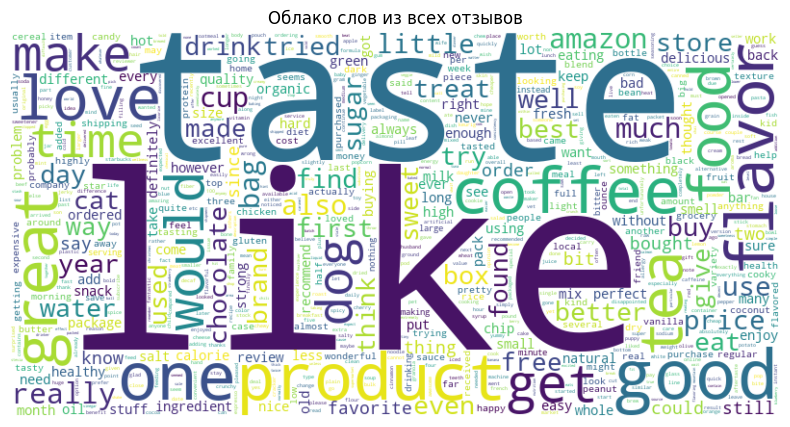


Статистика облака слов:
Всего слов: 22,212,546
Уникальных слов: 102,868
Отображено слов в облаке: 1,000

Топ-10 самых частых слов:
like: 267,989 раз
taste: 218,478 раз
good: 202,409 раз
one: 193,158 раз
flavor: 187,631 раз
product: 184,157 раз
coffee: 176,314 раз
great: 167,191 раз
love: 163,993 раз
tea: 153,852 раз


In [54]:
create_wordcloud(df, max_words=1000, batch_size=1000)

Так же с помощью Counter() подсчитываем частоту слов

In [55]:
def plot_word_frequencies(df):
    # Объединяем все токены
    all_words = [word for tokens in df['Tokens'].dropna() for word in tokens]
    
    # Считаем частоту слов
    word_freq = Counter(all_words)
    
    # Берем топ-20 слов
    top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]
    words, freqs = zip(*top_words)
    
    # Строим график
    plt.figure(figsize=(12, 6))
    plt.bar(words, freqs)
    plt.xticks(rotation=45, ha='right')
    plt.title('Топ-20 самых частых слов')
    plt.xlabel('Слова')
    plt.ylabel('Частота')
    plt.tight_layout()
    plt.show()

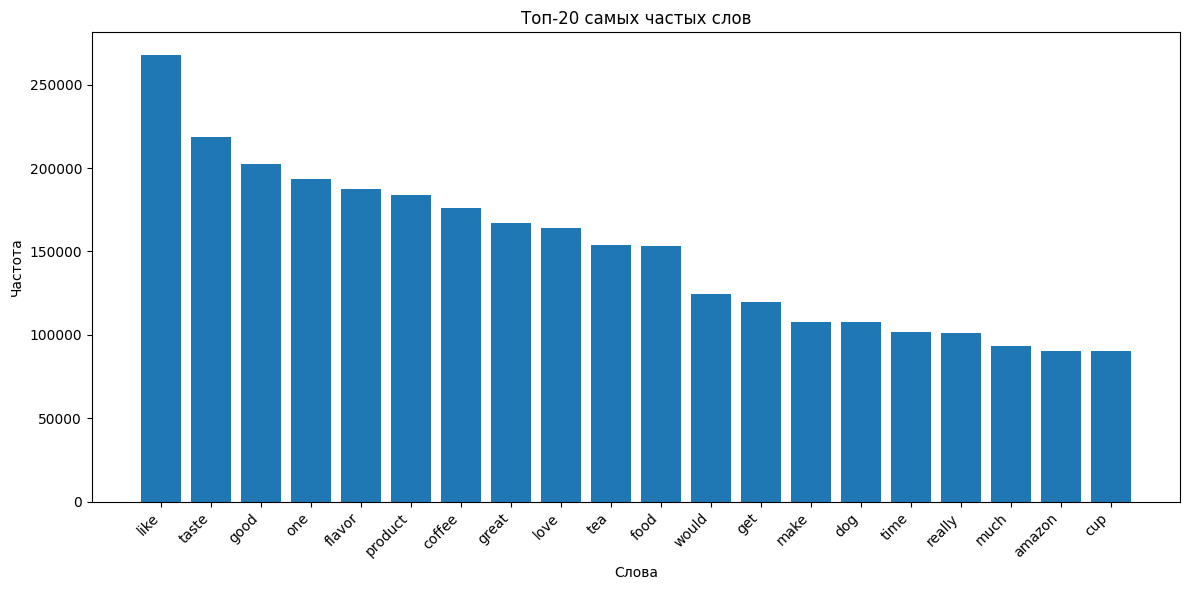

In [56]:
plot_word_frequencies(df)

In [63]:
def analyze_rating_length_correlation(df):
    # Точечный график
    sns.boxplot(data=df, x='Score', y='word_count')
    plt.title('Зависимость длины отзыва от оценки')
    plt.xlabel('Оценка')
    plt.ylabel('Количество слов')
    
    plt.tight_layout()
    plt.show()
    
    # Вычисляем корреляцию
    correlation = df['Score'].corr(df['word_count'])
    print(f"\nКорреляция между оценкой и длиной отзыва: {correlation:.3f}")

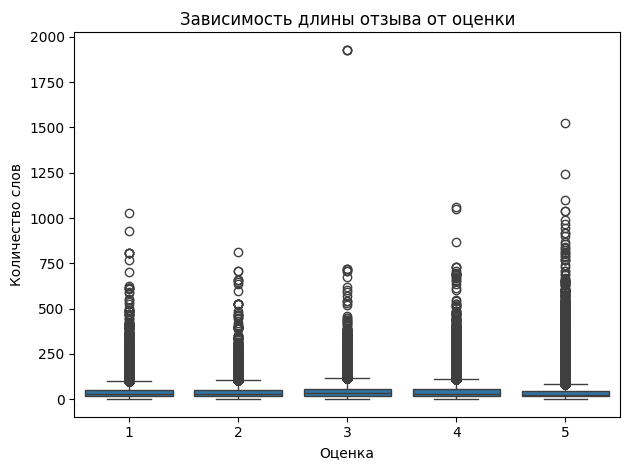


Корреляция между оценкой и длиной отзыва: -0.068


In [64]:
analyze_rating_length_correlation(df)

В результате мы видим следующую закономерность: самые плохие отзывы и самые хорошие отзывы имеют большую длину, чем менее критичные и нейтральные отзывы, за исключением нескольких выбросов. Это можно объяснить психологией людей, что они более склонны к детальному описанию своего опыта при ярких эмоциях - позитивных или негативных.